In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score

import time

In [2]:
data = pd.read_csv("Data.csv")
desc = pd.read_csv("Description.csv", header=None)

In [3]:
for i in range(desc.shape[0]):
    print(desc.loc[i,0]+'\n')

X1: Сумма предоставленного кредита (NT доллар): включает как индивидуальный потребительский кредит, так и его/ее семейный (дополнительный) кредит.

X2: Пол (1 = мужской; 2 = женский).

X3: Образование (1 = аспирантура, 2 = университет, 3 = средняя школа, 4 = другое).

X4: Семейное положение (1 = женат, 2 = холост, 3 = другие).

X5: Возраст (год).

X6 - X11: История прошлых платежей. Были отслежены записи прошлых ежемесячных платежей (с апреля по сентябрь 2005 г.) следующим образом: X6 = статус погашения в сентябре 2005 г.; X7 = статус погашения в августе 2005 г.; . . .;X11 = статус погашения в апреле 2005 г. 

Шкала измерения для статуса погашения: -1 = платить должным образом; 1 = отсрочка платежа на один месяц; 2 = отсрочка платежа на два месяца; . . .; 8 = отсрочка платежа на восемь месяцев; 9 = задержка платежа на девять месяцев и более.

X12-X17: Сумма выписки по счету (NT доллар). X12 = сумма выписки по векселю в сентябре 2005 г.; X13 = сумма выписки по векселю за август 2005 г.;

In [4]:
data = data.iloc[1:,1:]

In [5]:
d = {'X1':'int', 'X5':'int', 'Y':'int'}
for i in range(12,23+1):
    d[f'X{i}']='int'
data = data.astype(dtype=d)

def modify(x):
    gender = {'1':'М', '2':'Ж'} #X2
    edu = {'1':'Аспирантура','2':'Университет','3':'Ср. школа','4':'Другое','0':'Другое','5':'Другое','6':'Другое'} #X3
    marr = {'1':'Женат','2':'Холост','3':'Другие', '0':'Другие'} #X4
    x['X2'] = gender[x['X2']]
    x['X3'] = edu[x['X3']]
    x['X4'] = marr[x['X4']]
    return x

data = data.apply(func=modify, axis=1)

In [6]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
1,20000,Ж,Университет,Женат,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,Ж,Университет,Холост,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,Ж,Университет,Холост,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,Ж,Университет,Женат,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,М,Университет,Женат,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Попытка без OHE признаков Х6-Х11

Преобразуем тип данных у этих признаков

In [7]:
data_ = pd.get_dummies(data, columns=['X2','X3','X4'], prefix=['Пол', 'Обр', 'СП'])

In [8]:
data_.head()

,X1,X5,X6,X7,X8,X9,X10,X11,X12,X13,...,Y,Пол_Ж,Пол_М,Обр_Аспирантура,Обр_Другое,Обр_Ср. школа,Обр_Университет,СП_Другие,СП_Женат,СП_Холост
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,1,1,0,0,0,0,1,0,1,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,1,1,0,0,0,0,1,0,0,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,0,1,0,0,0,0,1,0,0,1
4,50000,37,0,0,0,0,0,0,46990,48233,...,0,1,0,0,0,0,1,0,1,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,0,0,1,0,0,0,1,0,1,0


In [9]:
d = {}
for i in range(6,11+1):
    d[f'X{i}']='int'
data_ = data_.astype(dtype=d)

Обучение

In [10]:
def learn_model(models, x_train, x_test, y_train, y_test):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        metrics = {'f1' : f1_score,
                   'accuracy' : accuracy_score,
                   'roc auc score' : roc_auc_score}
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])
        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        print(results)
    
    def fit_model():
        learned_model = {}
        for model in models.keys():
            model_learn =  models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            grid = GridSearchCV(model_learn, cv=5, param_grid=params, n_jobs=-1, scoring = 'f1')
            grid.fit(x_train, y_train)
            fit_time = round(time.time() - start_time,2)
            
            print(f'__________{model}_{fit_time}_сек.________')
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            learned_model[model]
            train_predict = grid.predict(x_train)
            test_predict = grid.predict(x_test)
            
            predicted = predict(model, train_predict, y_train, test_predict, y_test)
        
        return learned_model

    result_model = fit_model()    
    return result_model

In [11]:
y = data_['Y']
x = data_.drop(columns='Y')

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [13]:
models = {'DecisionTreeClassifier' : [DecisionTreeClassifier(), {'criterion':['gini', 'entropy'],
                                                                 'max_depth':[None,2,3,4,5,6,7,8,9,10,11,12,13,14,15],            
                                                                 'min_samples_split':[2,4,6,8,10,12,14,16,18]}]}

In [14]:
tree1 = learn_model(models, x_train, x_test, y_train, y_test)

__________DecisionTreeClassifier_104.35_сек.________
                  train      test
f1             0.483275  0.483917
accuracy       0.821708  0.820833
roc auc score  0.662348  0.663505


In [15]:
tree1

{'DecisionTreeClassifier': [GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
               param_grid={'criterion': ['gini', 'entropy'],
                           'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15],
                           'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18]},
               scoring='f1'),
  {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}]}

## Попытка c OHE признаков Х6-Х11

Преобразуем данных

In [16]:
data_ = pd.get_dummies(data, columns=['X2','X3','X4'], prefix=['Пол', 'Обр', 'СП'])

In [17]:
data_ = pd.get_dummies(data_, columns=['X6','X7','X8','X9','X10','X11'])

In [18]:
data_.head()

,X1,X5,X12,X13,X14,X15,X16,X17,X18,X19,...,X11_-1,X11_-2,X11_0,X11_2,X11_3,X11_4,X11_5,X11_6,X11_7,X11_8
1,20000,24,3913,3102,689,0,0,0,0,689,...,0,1,0,0,0,0,0,0,0,0
2,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
3,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
4,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
5,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


Обучение

In [19]:
y = data_['Y']
x = data_.drop(columns='Y')

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [21]:
tree2 = learn_model(models, x_train, x_test, y_train, y_test)

__________DecisionTreeClassifier_127.82_сек.________
                  train      test
f1             0.516074  0.436655
accuracy       0.834417  0.812500
roc auc score  0.678347  0.639760


In [22]:
tree2

{'DecisionTreeClassifier': [GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
               param_grid={'criterion': ['gini', 'entropy'],
                           'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15],
                           'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18]},
               scoring='f1'),
  {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 16}]}

## В первом случае дерево получилось более устойчивое по оценкам кросс валидации и в целом показало результат повыше, поэтому остановимся на случае 1

In [23]:
data_ = pd.get_dummies(data, columns=['X2','X3','X4'], prefix=['Пол', 'Обр', 'СП'])

In [24]:
d = {}
for i in range(6,11+1):
    d[f'X{i}']='int'
data_ = data_.astype(dtype=d)

In [25]:
y = data_['Y']
x = data_.drop(columns='Y')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [26]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_split = 6).fit(x_train, y_train)

In [27]:
y_train_predict = tree.predict(x_train)
y_test_predict = tree.predict(x_test)
columns = ['train', 'test']
lst=[]
metrics = {'f1' : f1_score,'accuracy' : accuracy_score,'roc auc score' : roc_auc_score}
for metric in metrics.keys():
            lst.append([metrics[metric](y_train, y_train_predict) ,metrics[metric](y_test, y_test_predict)])
results = pd.DataFrame(data=lst, index=metrics.keys(), columns=columns)

In [28]:
results

,train,test
f1,0.487132,0.468843
accuracy,0.828125,0.821000
roc auc score,0.663794,0.654855


## Ответы на вопросы 

Посмотреть метрику ROC AUC на обучающей и тестовой выборках. Сильно ли меняется её качество?
<br/>Ответ: На хорошем дереве качество изменилось не сильно

Какие признаки получились наиболее важными (feature importance)?

In [29]:
tree_importances = pd.Series(tree.feature_importances_, index=x.columns).sort_values(ascending=False)

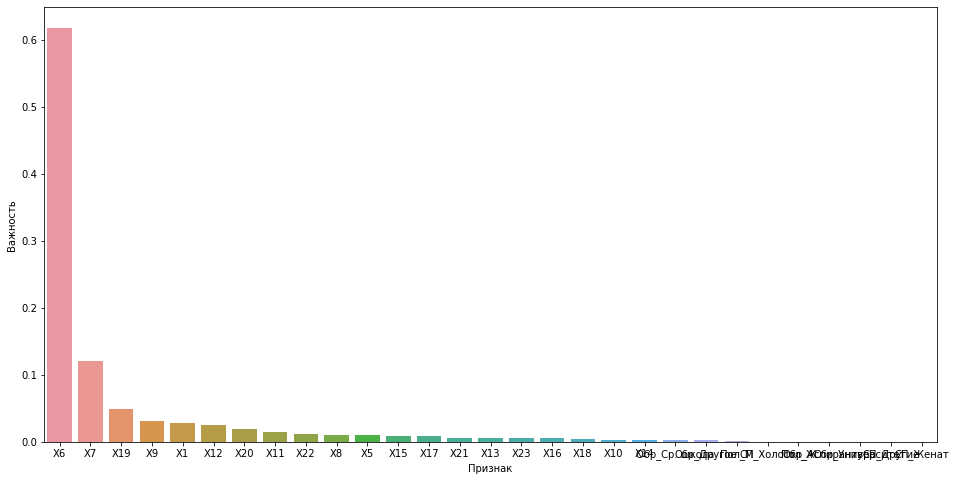

In [30]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x = tree_importances.index, y = tree_importances.values)
ax.set_ylabel("Важность")
ax.set_xlabel("Признак")
plt.show(ax)

<br/>Ответ: X6 и X7 получились наиболее важными (это статусы ежемесячного платежа, заплачен исправно или получена отсрочка, за сентябрь и август)

Можно ли объяснить именно такое распределение признаков по важности?
<br/>Ответ: Так как мы расчитываем вероятность дефолта клиента в следующем месяце (как я понимаю в октябре), то важнне всего как он платит по кредиту в последнее время. Наверное так можно объяснить

## Визуализация дерева

In [31]:
tree

DecisionTreeClassifier(max_depth=7, min_samples_split=6)

Дерево получилось довольно глубоким, поэтому я выведу лишь его часть

In [32]:
import pydotplus
from sklearn.tree import export_graphviz

In [33]:
dot_data=export_graphviz(tree, max_depth = 4, filled=True, rounded=True, feature_names = x.columns, precision=2)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')  

True

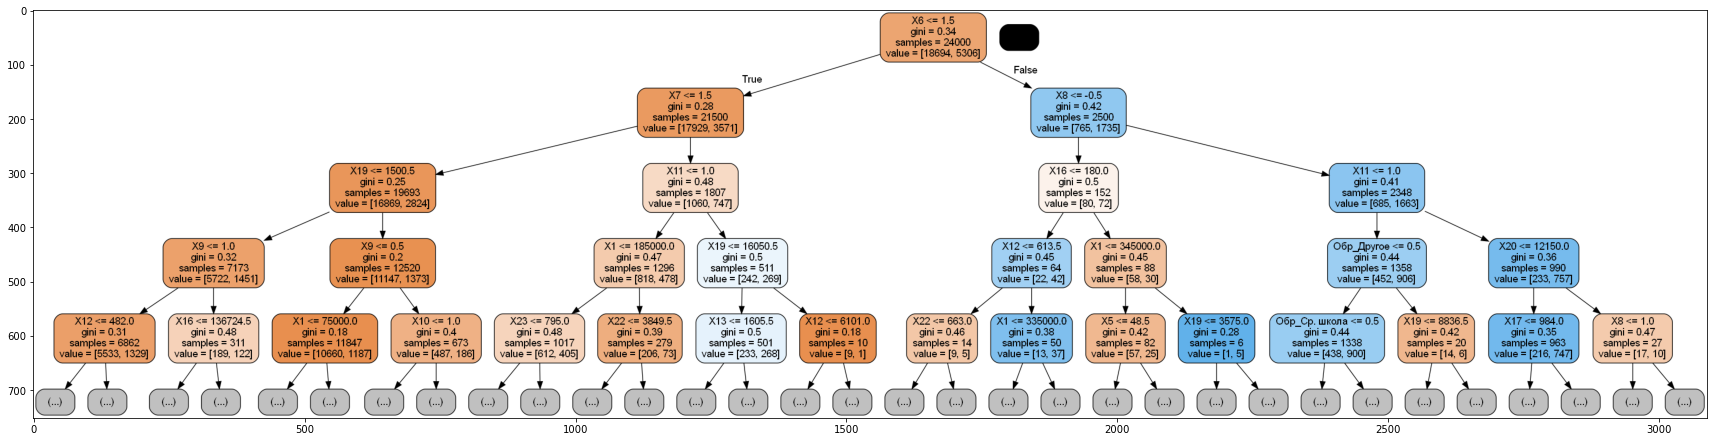

In [34]:
plt.figure(figsize=(30,15))
plt.imshow(plt.imread('tree.png'))
plt.show()